In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, SAGPooling, ASAPooling, EdgePooling
from torch_geometric.data import Data
import os
import h5py
import torch.utils.data as data
from sklearn import preprocessing
import numpy as np
from tqdm.notebook import tqdm
base = 'data/modelnet/modelnet_graph_k15/'
paths = []
labels = []
for obj in os.listdir(base):
    temp = base + obj
    if obj in ['sofa', 'airplane', 'vase', 'chair', 'toilet', 'bookshelf', 'bed', 'monitor', 'piano', 'bottle']:
        for file in os.listdir(temp):
            paths.append(temp+'/' + file)
            labels.append(obj)

In [11]:
for obj in os.listdir(base):
    print(obj, len(os.listdir(base + obj)))

sofa 600
xbox 106
bowl 56
bathtub 123
airplane 726
cone 47
glass_box 146
radio 108
lamp 118
monitor 376
plant 293
vase 442
bookshelf 333
stairs 104
stool 79
person 101
keyboard 162
laptop 104
night_stand 163
door 78
bench 128
table 271
flower_pot 142
bottle 358
curtain 122
piano 308
mantel 369
sink 132
bed 457
guitar 247
car 297
desk 184
chair 868
cup 54
dresser 184
wardrobe 48
tv_stand 186
toilet 394
tent 87
range_hood 183


In [13]:
class GCNdata(data.Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        le = preprocessing.LabelEncoder()
        self.labels = le.fit_transform(labels)
    def __getitem__(self, index):
        f = h5py.File(self.paths[index], 'r')
        edge_w = f['edge_weight'][:]
        edges = f['edges'][:]
        nodes = f['nodes'][:]
        edges = torch.tensor(edges, dtype = torch.long)
        x = torch.tensor(nodes, dtype=torch.float)
        weights = torch.tensor(edge_w, dtype=torch.float)
        f.close()
        y = torch.from_numpy(np.array(self.labels[index]))
        return x, edges, weights, y
    
    def __len__(self):
        return len(self.paths)

In [17]:
dataset = GCNdata(paths, labels)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [4000, 862])

In [15]:
len(dataset)

4862

In [18]:
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16, add_self_loops = True, normalize = True)
        self.conv2 = GCNConv(16, 32, add_self_loops = True, normalize = True)
        self.pool1 = SAGPooling(in_channels=16, ratio=0.5)
        self.pool2 = SAGPooling(in_channels=32, ratio=0.5)
        self.conv3 = GCNConv(32, 32, add_self_loops = True, normalize = True)
        self.conv4 = GCNConv(32, 10, add_self_loops = True, normalize = True)
        
    def forward(self, x, edge_index, edge_attr):
        x = x.view(-1, 3)
        edge_index = edge_index.view(2, -1)
        edge_attr = edge_attr.view(-1)
        #print(edge_index.shape, edge_index.type)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        temp = self.pool1(x, edge_index, edge_attr)
        x, edge_index, edge_attr = temp[0], temp[1], temp[2]
        
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        temp = self.pool2(x, edge_index, edge_attr)
        x, edge_index, edge_attr = temp[0], temp[1], temp[2]
        
        x = self.conv3(x, edge_index, edge_attr)
        x = F.relu(x)
        
        x = self.conv4(x, edge_index, edge_attr)
        x = F.relu(x)
        x = torch.max(x, dim=0, keepdim=True)[0]
        return F.log_softmax(x, dim=1)

In [19]:
class GCN_PointNet(nn.Module):
    def __init__(self):
        super(GCN_PointNet, self).__init__()
        self.input = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.mlp_first = nn.Sequential(
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.mlp_second = nn.Sequential(
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 200, 1),
            nn.BatchNorm1d(200),
            nn.ReLU()
        )
        self.mlp_third = nn.Sequential(
            nn.Conv1d(200, 128, 1),
            nn.ReLU(),
            nn.Conv1d(128, 2, 1),
            nn.ReLU()
        )
        self.pool1 = SAGPooling(in_channels=64, ratio=0.5)
        self.pool2 = SAGPooling(in_channels=200, ratio=0.2)
        
        
    def forward(self, x, edge_index, edge_attr):
        x = torch.transpose(x, 1, 2)
        #print(x.shape)
        edge_index = edge_index.view(2, -1)
        edge_attr = edge_attr.view(-1)
        x = self.input(x)
        x = self.mlp_first(x)
        
        #print(x.shape)
        x = torch.transpose(x, 1, 2)
        x = x.view(1000, 64)
        temp = self.pool1(x, edge_index, edge_attr)
        x, edge_index, edge_attr = temp[0], temp[1], temp[2]
        x = x.view(1, 500, 64)
        x = torch.transpose(x, 1, 2)
        
        #print(x.shape)
        x = self.mlp_second(x)
        
        #print(x.shape)
        x = torch.transpose(x, 1, 2)
        x = x.view(500, 200)
        temp = self.pool2(x, edge_index, edge_attr)
        x, edge_index, edge_attr = temp[0], temp[1], temp[2]
        x = x.view(1, 100, 200)
        x = torch.transpose(x, 1, 2)
        
        #print(x.shape)
        x = F.max_pool1d(x, 100)
        #print(x.shape)
        x = self.mlp_third(x)
        #print(x.shape)
        x = x.squeeze(2)
        #print(x.shape)
        return F.log_softmax(x, dim=1)

In [20]:
class Trainer():
    
    def __init__(self,model,train_set,test_set,opts):
        self.model = model  # neural net
        
        # device agnostic code snippet
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.epochs = opts['epochs']
        print(model)
        self.optimizer = torch.optim.Adam(model.parameters(), opts['lr']) # optimizer method for gradient descent
        self.criterion = torch.nn.CrossEntropyLoss()                      # loss function
        self.train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                                        batch_size=1,
                                                        shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                                       batch_size=1,
                                                       shuffle=True)
        self.batch = opts['batch_size']
        self.stats = []
        
    def train(self):
        self.model.train() #put model in training mode
        for epoch in range(self.epochs):
            self.tr_loss = []
            for i, (x, edges, weights, labels) in tqdm(enumerate(self.train_loader),
                                                   total = len(self.train_loader)):
                x, edges, weights, labels = x.to(self.device), edges.to(self.device), weights.to(self.device), labels.to(self.device)
                #print(labels)
                if i % self.batch == 0 or i==len(self.train_loader):
                    if i != 0:
                        self.optimizer.zero_grad()
                        loss = self.criterion(out, label)
                        out = self.model(x, edges, weights)
                        loss.backward()                        
                        self.optimizer.step()                  
                        self.tr_loss.append(loss.item())
                        print(loss.item())
                    out = self.model(x, edges, weights)
                    label = labels
                else:
                    out = torch.cat((out, self.model(x, edges, weights)), 0)
                    label = torch.cat((label, labels), 0)
            self.test(epoch) # run through the validation set
        
    def test(self,epoch):
            
            self.model.eval()    # puts model in eval mode - not necessary for this demo but good to know
            self.test_loss = []
            self.test_accuracy = []
            
            for i, (x, edges, weights, labels) in enumerate(self.test_loader):
                
                x, edges, weights, labels = x.to(self.device), edges.to(self.device), weights.to(self.device), labels.to(self.device)
                # pass data through network
                # turn off gradient calculation to speed up calcs and reduce memory
                with torch.no_grad():
                    outputs = self.model(x, edges, weights)
                
                # make our predictions and update our loss info
                _, predicted = torch.max(outputs.data, 1)
                loss = self.criterion(outputs, labels)
                self.test_loss.append(loss.item())
                
                self.test_accuracy.append((predicted == labels).sum().item() / predicted.size(0))
            
            print('epoch: {}, train loss: {}, test loss: {}, test accuracy: {}'.format( 
                  epoch+1, np.mean(self.tr_loss), np.mean(self.test_loss), np.mean(self.test_accuracy)))
            self.stats.append((epoch+1, np.mean(self.tr_loss), np.mean(self.test_loss), np.mean(self.test_accuracy)))
            
    def get_stats(self):
        return self.stats

In [22]:
model = GCN()
opts = {
    'lr': 1e-3,
    'epochs': 20,
    'batch_size': 64
}

Train = Trainer(model = model,
                      train_set = train_dataset,
                      test_set = test_dataset,opts = opts)

Train.train()

GCN(
  (conv1): GCNConv(3, 16)
  (conv2): GCNConv(16, 32)
  (pool1): SAGPooling(GraphConv, 16, ratio=0.5, multiplier=1)
  (pool2): SAGPooling(GraphConv, 32, ratio=0.5, multiplier=1)
  (conv3): GCNConv(32, 32)
  (conv4): GCNConv(32, 10)
)


  0%|          | 0/4000 [00:00<?, ?it/s]

2.3022215366363525
2.304325580596924
2.3010802268981934
2.2986671924591064
2.2991111278533936
2.299220561981201
2.298807382583618
2.2987396717071533
2.2973580360412598
2.296206474304199
2.2923989295959473
2.2960920333862305
2.298576831817627
2.2892303466796875
2.2957940101623535
2.29648756980896
2.2926247119903564
2.2904069423675537
2.288862943649292
2.297222137451172
2.2775962352752686
2.2924342155456543
2.2922167778015137
2.2964019775390625
2.293306827545166
2.297424077987671
2.2829861640930176
2.2819268703460693
2.286512851715088
2.281425714492798
2.274902582168579
2.2753195762634277
2.283686637878418
2.287276029586792
2.2721519470214844
2.2761127948760986
2.280527353286743
2.2701120376586914
2.277756690979004
2.2926368713378906
2.274973154067993
2.2800686359405518
2.2802529335021973
2.275740146636963
2.274653673171997
2.266270160675049
2.275400161743164
2.3006198406219482
2.252211093902588
2.2697744369506836
2.2809972763061523
2.277089834213257
2.255084991455078
2.259591579437256
2

  0%|          | 0/4000 [00:00<?, ?it/s]

2.223844528198242
2.221808910369873
2.2794077396392822
2.194728136062622
2.257357358932495
2.2065036296844482
2.223587989807129
2.257584810256958
2.258582592010498
2.218132495880127
2.2707021236419678
2.2628347873687744
2.227930784225464
2.2769527435302734
2.239853858947754
2.2648255825042725
2.222015380859375
2.248105525970459
2.2187492847442627
2.256405830383301
2.2557084560394287
2.2470030784606934
2.2800331115722656
2.2256062030792236
2.2523796558380127
2.268254518508911
2.2362403869628906
2.204892873764038
2.188352346420288
2.256054639816284
2.2010645866394043
2.2205090522766113
2.2009241580963135
2.189199209213257
2.233924388885498
2.1898534297943115
2.1932296752929688
2.251243829727173
2.2220706939697266
2.242154121398926
2.158947467803955
2.1799423694610596
2.217758893966675
2.2273521423339844
2.2496166229248047
2.150588274002075
2.2342519760131836
2.1384012699127197
2.1601362228393555
2.048110008239746
2.1706933975219727
2.1267662048339844
2.2197041511535645
2.1392242908477783

  0%|          | 0/4000 [00:00<?, ?it/s]

2.15735125541687
2.1361775398254395
2.2427892684936523
2.060408353805542
2.1435179710388184
2.177429437637329
2.076854705810547
2.259676218032837
2.243952751159668
2.1770453453063965
2.081918239593506
2.1604373455047607
2.0416173934936523
2.025026559829712
2.128872871398926
2.122772693634033
2.081561326980591
2.1235337257385254
2.1824893951416016
2.1268298625946045
2.055880069732666
2.1592657566070557
2.096184015274048
2.1132874488830566
1.9439067840576172
1.979897379875183
1.9094853401184082
2.095404624938965
2.1047346591949463
2.1264421939849854
2.094944477081299
2.2154345512390137
1.9873055219650269
2.0756924152374268
2.038382053375244
2.0606613159179688
2.0439000129699707
2.240659713745117
2.1087822914123535
1.9514946937561035
1.9830787181854248
1.970003604888916
2.1698696613311768
2.107051134109497
2.2634689807891846
2.024712324142456
2.042987108230591
2.207791566848755
2.0870847702026367
2.0941455364227295
2.003007411956787
2.129319667816162
2.09059739112854
2.113823175430298
1.9

  0%|          | 0/4000 [00:00<?, ?it/s]

2.0118417739868164
1.9976133108139038
2.102065086364746
2.1836254596710205
2.120896339416504
1.930972933769226
2.011096477508545
1.9618284702301025
2.18359375
2.022449493408203
1.9901783466339111
1.9379547834396362
2.0145633220672607
2.138324737548828
2.0566115379333496
1.9892016649246216
2.1690995693206787
2.052719831466675
1.9329456090927124
2.1036901473999023
1.990875244140625
2.0777082443237305
2.0177133083343506
2.0431835651397705
1.9173156023025513
1.9852451086044312
1.9687676429748535
2.0311977863311768
2.002053737640381
2.0944838523864746
1.9843730926513672
2.020282030105591
1.9046311378479004
1.8435611724853516
2.088937520980835
2.007049798965454
2.0362961292266846
1.9496461153030396
1.9761161804199219
2.099628210067749
2.051189661026001
2.1700191497802734
1.9281542301177979
1.930054783821106
1.9500614404678345
1.9263203144073486
2.0131969451904297
2.0430684089660645
2.080167055130005
1.997236967086792
2.0169517993927
1.85927414894104
1.9811972379684448
2.0201756954193115
1.93

  0%|          | 0/4000 [00:00<?, ?it/s]

1.9179325103759766
2.023129463195801
1.8937090635299683
1.990665078163147
1.9572447538375854
1.960959792137146
2.012787103652954
1.7291947603225708
2.0609774589538574
1.9058496952056885
2.1400060653686523
2.043646812438965
1.8597779273986816
1.9858318567276
2.121945381164551
2.0588626861572266
1.9520119428634644
1.9541277885437012
1.9799654483795166
1.9582003355026245
1.9097973108291626
1.9841285943984985
1.7736976146697998
1.9947696924209595
1.7601630687713623
2.043311834335327
2.028075695037842
1.9201165437698364
2.049105405807495
1.9186676740646362
1.7944483757019043
2.062274932861328
1.9960730075836182
1.791886568069458
1.9213755130767822
1.8781689405441284
2.141650676727295
1.826163649559021
1.9549776315689087
1.9320768117904663
1.9294884204864502
1.8516569137573242
1.990798830986023
1.8874036073684692
1.8866777420043945
1.928400993347168
1.908884882926941
2.0816099643707275
1.85141921043396
2.047926425933838
1.9938021898269653
1.7856451272964478
1.9302361011505127
1.9539566040039

  0%|          | 0/4000 [00:00<?, ?it/s]

1.9218671321868896
2.0287208557128906
1.964418649673462
1.8604015111923218
1.930602788925171
1.8478846549987793
1.7910710573196411
1.93994140625
1.9373831748962402
1.9896539449691772
1.9277207851409912
1.8291816711425781
1.9590282440185547
1.858755350112915
2.0890233516693115
1.7521260976791382
1.802314043045044
1.9464668035507202
1.8699283599853516
1.8213996887207031
1.885327935218811
1.9135942459106445
1.843788504600525
1.9991203546524048
2.0795178413391113
1.8980714082717896
1.7909212112426758
1.849014163017273
1.9159960746765137
1.9523893594741821
1.8232438564300537
1.9604791402816772
1.8467215299606323
1.7814666032791138
1.881141185760498
1.8871557712554932
1.992958903312683
1.9514424800872803
1.7685471773147583
1.9094860553741455
1.7313110828399658
1.9208416938781738
1.7376490831375122
1.8464136123657227
2.166781425476074
2.068620204925537
1.866932988166809
1.7198996543884277
1.8642997741699219
1.8387267589569092
1.8549689054489136
1.8535077571868896
2.12629771232605
1.7170988321

  0%|          | 0/4000 [00:00<?, ?it/s]

1.7547552585601807
1.7664798498153687
1.755563497543335
2.120364189147949
1.9773988723754883
1.768242597579956
1.7265102863311768
1.861279845237732
2.024351119995117
1.9172720909118652
1.8798481225967407
1.8114546537399292
1.851785659790039
1.797739028930664
1.735177755355835
1.8622076511383057
2.0036087036132812
1.6626906394958496
1.825353741645813
1.908116102218628
2.0469682216644287
1.9079746007919312
1.7703508138656616
1.7703101634979248
1.767360806465149
1.7330679893493652
2.026752471923828
1.9004284143447876
1.7872649431228638
2.025747299194336
1.8600558042526245
1.9831898212432861
1.969788908958435
1.6402617692947388
1.7220425605773926
1.9278229475021362
1.9108532667160034
1.8728327751159668
1.7368886470794678
1.992865800857544
1.931011438369751
1.6804174184799194
1.8310167789459229
1.890486478805542
2.0356194972991943
1.986603856086731
1.8107261657714844
1.7483593225479126
1.9795725345611572
1.7129225730895996
2.0106863975524902
1.7481584548950195
1.9474354982376099
2.001222610

  0%|          | 0/4000 [00:00<?, ?it/s]

1.7743934392929077
1.904125452041626
1.986477017402649
1.795799970626831
2.0589547157287598
1.731012225151062
1.7329392433166504
1.600394606590271
1.8624303340911865
1.6262867450714111
1.9896270036697388
1.9979727268218994
1.7312443256378174
1.782110571861267
1.8250353336334229
1.8985271453857422
1.8176854848861694
1.7507292032241821
1.841200351715088
1.8748571872711182
2.0449564456939697
1.8785314559936523
1.9490312337875366
2.0425925254821777
1.806577205657959
1.8716273307800293
1.8839824199676514
1.8799954652786255
1.9588911533355713
1.9478240013122559
1.8716439008712769
1.6899484395980835
1.825498342514038
1.8124514818191528
1.8772227764129639
1.710060477256775
2.0954437255859375
1.8871796131134033
1.6675450801849365
1.946670413017273
1.6276121139526367
1.8700673580169678
1.797385811805725
1.744207501411438
1.842369556427002
1.8054217100143433
1.764939546585083
1.8977880477905273
1.9776180982589722
1.8070398569107056
1.666343092918396
1.870659351348877
1.9056447744369507
1.88471603

  0%|          | 0/4000 [00:00<?, ?it/s]

1.7170425653457642
1.9997437000274658
1.996668815612793
1.888343095779419
2.0106403827667236
1.6012165546417236
1.7761914730072021
2.177480936050415
2.073484182357788
1.9890133142471313
1.7682654857635498
1.8036258220672607
1.7666939496994019
2.056910514831543
1.6965782642364502
1.8339464664459229
2.0793890953063965
1.8237093687057495
1.8392060995101929
1.784761905670166
1.7322096824645996
1.8257304430007935
1.670426607131958
1.6657099723815918
1.8625231981277466
1.6308064460754395
1.8592976331710815
1.854379653930664
1.706465721130371
1.6696535348892212
1.808997631072998
1.8425992727279663
1.7996560335159302
1.8401083946228027
1.8199560642242432
1.6869462728500366
1.6997729539871216
1.9687308073043823
1.855063557624817
1.9718656539916992
1.8439019918441772
1.772788166999817
1.9012937545776367
1.969886064529419
1.6158232688903809
1.7052133083343506
1.9013804197311401
1.7178698778152466
1.8219245672225952
1.974094271659851
1.7669748067855835
1.7575241327285767
1.7261900901794434
1.50838

  0%|          | 0/4000 [00:00<?, ?it/s]

1.8825311660766602
1.7987592220306396
1.944405198097229
1.9552184343338013
1.813549280166626
1.8637495040893555
1.9500378370285034
1.9682750701904297
1.8476171493530273
1.9771888256072998
1.7509604692459106
1.869089961051941
1.8000781536102295
1.808795690536499
1.853531002998352
1.9657574892044067
1.9357482194900513
1.791405200958252
1.854177474975586
1.8491945266723633
1.674943208694458
1.9059211015701294
1.8037983179092407
1.6981879472732544
1.728103756904602
1.8318171501159668
1.6891943216323853
1.6987929344177246
1.8105634450912476
1.6591994762420654
1.745896339416504
1.7408744096755981
1.8517210483551025
1.6000739336013794
1.9821975231170654
1.9367200136184692
1.9487910270690918
1.7297452688217163
1.8894380331039429
1.9037977457046509
1.911091685295105
1.7592970132827759
1.686959981918335
1.7164583206176758
1.6639018058776855
1.7536643743515015
1.856391191482544
1.7580623626708984
1.9274945259094238
1.6391010284423828
1.808881402015686
1.7320533990859985
1.6211061477661133
1.80775

  0%|          | 0/4000 [00:00<?, ?it/s]

1.7903436422348022
1.8068259954452515
1.7214677333831787
1.7939035892486572
1.7675436735153198
1.6944350004196167
1.8187135457992554
1.6329108476638794
1.9017720222473145
1.7266887426376343
1.6472147703170776
1.7854928970336914
1.9931213855743408
1.7849494218826294
1.7184418439865112
1.6197744607925415
1.7839665412902832
2.006967544555664
1.683125615119934
1.625903844833374
1.715247631072998
1.8459887504577637
1.5479927062988281
1.6572744846343994
1.7992844581604004
1.8003069162368774
1.6929126977920532
1.5737409591674805
1.6764883995056152
1.7552361488342285
1.7545571327209473
1.6899700164794922
1.7344704866409302
1.608443021774292
1.7389488220214844
1.6854526996612549
1.9294637441635132
1.7604345083236694
1.6874008178710938
1.7056666612625122
1.5853878259658813
1.7842533588409424
1.765953779220581
1.794533610343933
1.7358216047286987
1.588134527206421
1.5062121152877808
1.7940402030944824
1.5012277364730835
1.7574596405029297
1.792167067527771
1.5342600345611572
1.7916146516799927
1.

  0%|          | 0/4000 [00:00<?, ?it/s]

1.5534906387329102
1.5126324892044067
1.7347151041030884
1.72213613986969
1.7465345859527588
1.6476671695709229
1.810499668121338
1.7861957550048828
1.5198248624801636
1.7297837734222412
1.7537723779678345
1.469299077987671
1.6719309091567993
1.6234800815582275
1.858607292175293
1.752758264541626
1.7141577005386353
1.6448763608932495
1.7935748100280762
1.654489517211914
1.9271317720413208
1.7821354866027832
1.7769596576690674
1.6830838918685913
1.6833285093307495
1.4947575330734253
1.6444480419158936
1.5546000003814697
1.719911813735962
1.772990345954895
1.7381055355072021
1.756934642791748
1.5639578104019165
1.7231518030166626
1.8614740371704102
1.6650242805480957
1.8056073188781738
1.5175474882125854
1.7012405395507812
1.7121037244796753
1.6182830333709717
1.699772834777832
1.7029190063476562
1.5216034650802612
1.4938429594039917
1.644425630569458
1.64913010597229
1.8387632369995117
1.51736581325531
1.7279689311981201
1.7828905582427979
1.6809332370758057
1.4237112998962402
1.9370779

  0%|          | 0/4000 [00:00<?, ?it/s]

1.8570829629898071
1.6007167100906372
1.6085401773452759
1.5747312307357788
1.7129430770874023
1.372936487197876
1.671858549118042
1.5842103958129883
1.5355826616287231
1.7015646696090698
1.6626940965652466
1.8182721138000488
1.7434717416763306
1.723594307899475
1.7535008192062378
1.5688657760620117
1.6909703016281128
1.6802942752838135
1.7185035943984985
1.783305048942566
1.596549391746521
1.5964683294296265
1.7047832012176514
1.5571930408477783
1.6417300701141357
1.6349438428878784
1.6401461362838745
1.4488633871078491
1.636213779449463
1.578109860420227
1.590657114982605
1.6306946277618408
1.5992556810379028
1.6378942728042603
1.694203495979309
1.8961113691329956
1.6136950254440308
1.7602657079696655
1.587440848350525
1.5592385530471802
1.7397202253341675
1.6230030059814453
1.943907380104065
1.564899206161499
1.4632573127746582
1.735503911972046
1.7506407499313354
1.6667370796203613
1.9214977025985718
1.7866382598876953
1.6277034282684326
1.8096669912338257
1.2753798961639404
1.5823

  0%|          | 0/4000 [00:00<?, ?it/s]

1.5935640335083008
1.5711252689361572
1.6464688777923584
1.5361469984054565
1.8538116216659546
1.7342089414596558
1.5606435537338257
1.5148720741271973
1.4740628004074097
1.7245664596557617
1.5604926347732544
1.5454583168029785
1.5114370584487915
1.745259165763855
1.6316583156585693
1.8229174613952637
1.770351529121399
1.59975004196167
1.566596508026123
1.88113534450531
1.6775957345962524
1.6056909561157227
1.7110836505889893
1.7780237197875977
1.5604395866394043
1.6753196716308594
1.8350021839141846
1.664771318435669
1.4799212217330933
1.5765666961669922
1.4370249509811401
1.7034636735916138
1.459352970123291
1.57782781124115
1.5984745025634766
1.4873764514923096
1.6566652059555054
1.3986177444458008
1.5625088214874268
1.4929859638214111
1.4593030214309692
1.681664228439331
1.508915662765503
1.6372159719467163
1.6388715505599976
1.6617510318756104
1.4759554862976074
1.3937780857086182
1.6617083549499512
1.7649868726730347
1.7617541551589966
1.792923927307129
1.4180423021316528
1.45486

  0%|          | 0/4000 [00:00<?, ?it/s]

1.2428534030914307
1.445387363433838
1.5136058330535889
1.4945309162139893
1.6201763153076172
1.6934298276901245
1.5732463598251343
1.7224879264831543
1.4725053310394287
1.701019287109375
1.655739665031433
1.414340853691101
1.8814423084259033
1.5498201847076416
1.6577892303466797
1.5411827564239502
1.7349681854248047
1.7732986211776733
1.411342978477478
1.587928056716919
1.417765498161316
1.6936384439468384
1.60293710231781
1.535286545753479
1.5987669229507446
1.4486055374145508
1.6859160661697388
1.5835518836975098
1.5428920984268188
1.8495243787765503
1.4493666887283325
1.7470492124557495
1.5215238332748413
1.7133135795593262
1.714463233947754
1.4245436191558838
1.9096087217330933
1.4388020038604736
1.6105278730392456
1.589982032775879
1.4894925355911255
1.6406978368759155
1.52839994430542
1.6595709323883057
1.5599584579467773
1.579802393913269
1.556222677230835
1.642926812171936
1.6897581815719604
1.5489333868026733
1.456834077835083
1.4404449462890625
1.6160688400268555
1.643007159

  0%|          | 0/4000 [00:00<?, ?it/s]

1.53669011592865
1.4768205881118774
1.4418060779571533
1.4926522970199585
1.2682008743286133
1.5282483100891113
1.5177128314971924
1.4712892770767212
1.5517700910568237
1.6426466703414917
1.4815298318862915
1.8218363523483276
1.3226113319396973
1.7785322666168213
1.6288666725158691
1.8249329328536987
1.5435154438018799
1.3503000736236572
1.3740688562393188
1.314763069152832
1.9597247838974
1.4501911401748657
1.668416976928711
1.4437272548675537
1.6681474447250366
1.6747609376907349
1.3653470277786255
1.5602235794067383
1.4740862846374512
1.55901300907135
1.523675560951233
1.4332789182662964
1.8074926137924194
1.6255967617034912
1.705089807510376
1.4690531492233276
1.5901548862457275
1.6742295026779175
1.6495195627212524
1.8384088277816772
1.6452884674072266
1.6281715631484985
1.7115607261657715
1.3212378025054932
1.6648868322372437
1.476618766784668
1.6033070087432861
1.488702654838562
1.436201572418213
1.5185527801513672
1.6422549486160278
1.492331624031067
1.3551976680755615
1.331127

  0%|          | 0/4000 [00:00<?, ?it/s]

1.5914030075073242
1.5269229412078857
1.5599054098129272
1.418571949005127
1.5939295291900635
1.5551143884658813
1.9007809162139893
1.3267043828964233
1.7364758253097534
1.5904077291488647
1.475656270980835
1.492458701133728
1.688124179840088
1.6780974864959717
1.6792101860046387
1.4541317224502563
1.4341257810592651
1.4406094551086426
1.6122820377349854
1.4828547239303589
1.5024774074554443
1.4489755630493164
1.550673484802246
2.071884870529175
1.3733762502670288
1.3931161165237427
1.627397894859314
1.483088731765747
1.7967171669006348
1.3925223350524902
1.658926010131836
1.6190290451049805
1.4475154876708984
1.466115117073059
1.5905224084854126
1.5619194507598877
1.532673716545105
1.7432957887649536
1.2909384965896606
1.4532235860824585
1.381343960762024
1.5697462558746338
1.6022778749465942
1.6458932161331177
1.3170857429504395
1.5246838331222534
1.478744626045227
1.6069846153259277
1.7086381912231445
1.5804238319396973
1.5278209447860718
1.428518295288086
1.506596565246582
1.577600

  0%|          | 0/4000 [00:00<?, ?it/s]

1.30565345287323
1.3245363235473633
1.441884160041809
1.497132658958435
1.547318935394287
1.4583303928375244
1.7323247194290161
1.3264034986495972
1.4342074394226074
1.7228422164916992
1.4453110694885254
1.294341802597046
1.5714598894119263
1.571852684020996
1.4749572277069092
1.4513790607452393
1.5861414670944214
1.550070881843567
1.5966311693191528
1.5498183965682983
1.6897073984146118
1.8190598487854004
1.543773889541626
1.5648459196090698
1.761521816253662
1.3477116823196411
1.4018305540084839
1.5649676322937012
1.5473209619522095
1.905259132385254
1.5246602296829224
1.3535765409469604
1.8526076078414917
1.5996524095535278
1.5339686870574951
1.6223769187927246
1.4847887754440308
1.6100291013717651
1.6863714456558228
1.6338016986846924
1.716779112815857
1.555841088294983
1.5313996076583862
1.407709002494812
1.5587204694747925
1.3292568922042847
1.5020008087158203
1.4131815433502197
1.4701935052871704
1.374550223350525
1.5633070468902588
1.7102147340774536
1.5174922943115234
1.562028

  0%|          | 0/4000 [00:00<?, ?it/s]

1.3706023693084717
1.66744065284729
1.6875195503234863
1.3667293787002563
1.403480052947998
1.6702133417129517
1.5172291994094849
1.4854040145874023
1.3417948484420776
1.4093331098556519
1.2801321744918823
1.4817612171173096
1.6852197647094727
1.56621253490448
1.5692068338394165
1.549018144607544
1.4762035608291626
1.4532372951507568
1.4174635410308838
1.7205920219421387
1.193049430847168
1.4484143257141113
1.5061546564102173
1.6830233335494995
1.5650246143341064
1.5581997632980347
1.7160770893096924
1.6142244338989258
1.6005703210830688
1.5108294486999512
1.2900245189666748
1.8722057342529297
1.3653830289840698
1.6916664838790894
1.3792366981506348
1.4106340408325195
1.2734798192977905
1.4449070692062378
1.6048502922058105
1.4757543802261353
1.6729012727737427
1.440048098564148
1.4674583673477173
1.3759485483169556
1.4484953880310059
1.7366888523101807
1.4878554344177246
1.388008952140808
1.782464623451233
1.5282939672470093
1.5241155624389648
1.730215311050415
1.5136737823486328
1.45

  0%|          | 0/4000 [00:00<?, ?it/s]

1.6146868467330933
1.235103964805603
1.6111489534378052
1.4151480197906494
1.496444821357727
1.1557013988494873
1.4619431495666504
1.7799890041351318
1.2687647342681885
1.392393708229065
1.4915556907653809
1.518595814704895
1.6861652135849
1.5913177728652954
1.539333462715149
1.569374918937683
1.6279467344284058
1.653833031654358
1.4497672319412231
1.5366861820220947
1.4051820039749146
1.4049981832504272
1.5192240476608276
1.4579460620880127
1.7110888957977295
1.3260451555252075
1.6730859279632568
1.4326398372650146
1.4912867546081543
1.1651313304901123
1.3281669616699219
1.8112508058547974
1.6068097352981567
1.4998712539672852
1.3750771284103394
1.5322188138961792
1.4304554462432861
1.3150657415390015
1.4162012338638306
1.370913028717041
1.9576562643051147
1.5153074264526367
1.4541422128677368
1.4483681917190552
1.5044432878494263
1.5371198654174805
1.655757188796997
1.6323314905166626
1.3287843465805054
1.3627548217773438
1.6564949750900269
1.5333250761032104
1.4417855739593506
1.485

In [27]:
result = Train.get_stats()

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

epoch = [x[0] for x in result]
train_ls = [x[1] for x in result]
test_ls = [x[2] for x in result]
test_acc = [x[3] for x in result]

No handles with labels found to put in legend.


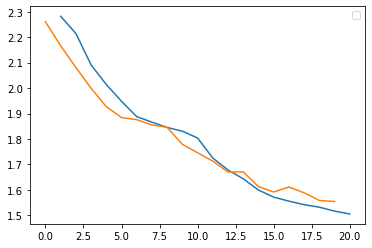

In [31]:
plt.plot(epoch, train_ls, test_ls)

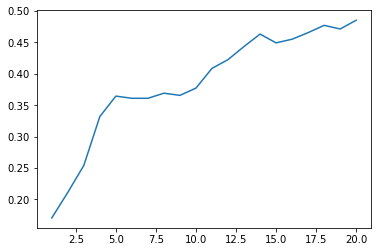

In [32]:
plt.plot(epoch, test_acc)